# Twitter

In [2]:
# Import required libraries
import twint
import nest_asyncio
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Yahoo API
import yfinance as yf

# NLP Packages
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# Bag of Words Model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler



nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

# This ensures the twint loop can run in jupyter notebook, no need to understand it
nest_asyncio.apply()

[nltk_data] Downloading package punkt to /Users/Roy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Roy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Roy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Initialize stocks of interest
# users = ["elonmusk", "michaeljburry"] # Elon Musk -> CEO of Tesla; Michael Burry -> Hedge Fund Manager
tickers = ["TSLA", "AAPL"] # Tesla stock and Bitcoin in USD

start_date = '2010-01-01'
end_date = '2021-01-01'

In [3]:
panel_data = yf.download(tickers=tickers, start=start_date, end=end_date)['Adj Close'].dropna(axis=0)
panel_data.head()

[*********************100%***********************]  2 of 2 completed


,AAPL,TSLA
Date,,
2010-06-29,7.880552,4.778
2010-06-30,7.737815,4.766
2010-07-01,7.643986,4.392
2010-07-02,7.596610,3.840
2010-07-06,7.648601,3.222


In [4]:
# obtain percentage change for each stock to use as the y variable in training
panel_data['AAPL_pct_change'] = panel_data['AAPL'].pct_change()
panel_data['TSLA_pct_change'] = panel_data['TSLA'].pct_change()

#ignore first row due to NaN
panel_data = panel_data.iloc[1:, :]
panel_data.head()

,AAPL,TSLA,AAPL_pct_change,TSLA_pct_change
Date,,,,
2010-06-30,7.737815,4.766,-0.018113,-0.002512
2010-07-01,7.643986,4.392,-0.012126,-0.078472
2010-07-02,7.596610,3.840,-0.006198,-0.125683
2010-07-06,7.648601,3.222,0.006844,-0.160938
2010-07-07,7.957460,3.160,0.040381,-0.019243


### TSLA

In [5]:
# # Use twint to grab tweets and put into pandas dataframe
# c = twint.Config()

# # set limitations of the parser
# c.Limit = 100000
# c.Lang = "en"

# # Set time frame
# c.Since = str(pd.to_datetime(panel_data.index.values[0])).split()[0]
# c.Until = str(pd.to_datetime(panel_data.index.values[-1])).split()[0]

# # Obtain pandas Dataframe
# c.Pandas = True

# # Search for TSLA posts
# c.Search = "#TSLA"

# # Scrape the user's twitter account
# twint.run.Search(c)

# # store in a dataframe
# TSLA_DF = twint.storage.panda.Tweets_df

### AAPL

In [6]:
# # Use twint to grab tweets and put into pandas dataframe
# c = twint.Config()

# # Set limitations of the parser
# c.Limit = 100000
# c.Lang = "en"

# # Set time frame
# c.Since = str(pd.to_datetime(panel_data.index.values[0])).split()[0]
# c.Until = str(pd.to_datetime(panel_data.index.values[-1])).split()[0]

# # Obtain pandas Dataframe
# c.Pandas = True

# c.Search = "#AAPL"
# # Scrape the user's twitter account
# twint.run.Search(c)

# # store in a dataframe
# AAPL_DF = twint.storage.panda.Tweets_df

In [7]:
# TSLA_DF.head()

In [8]:
# AAPL_DF.head()

In [9]:
# # Remove undesirable columns
# cols_to_be_removed = ['id', 'conversation_id', 'created_at', 'timezone', 'place',
#        'language', 'user_id',
#        'username', 'name', 'day', 'hour', 'urls', 'photos', 'video',
#        'thumbnail', 'quote_url', 'search',
#        'near', 'geo', 'source', 'reply_to', 'translate', 'trans_src',
#        'trans_dest', 'link', 'user_id_str', 'cashtags', 'hashtags', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'retweet']

# # drop unnecessary columns

# TSLA_DF = TSLA_DF.drop(cols_to_be_removed, inplace = False, axis=1)
# # TSLA_DF['simp_date'] = [str(i).split()[0] for i in pd.to_datetime(TSLA_DF['date'].values)]
# TSLA_DF.reset_index(drop=True, inplace=True)
# TSLA_DF


# AAPL_DF = AAPL_DF.drop(cols_to_be_removed, inplace = False, axis=1)
# # BTC_DF['simp_date'] = [str(i).split()[0] for i in pd.to_datetime(BTC_DF['date'].values)]
# AAPL_DF.reset_index(drop=True, inplace=True)
# AAPL_DF



# # TWEETS_DF = TWEETS_DF.drop(cols_to_be_removed, inplace = False, axis=1)
# # TWEETS_DF.reset_index(drop=True, inplace=True)
# # TWEETS_DF



### Notice how there are duplicate dates in our dataframe

In [10]:
# TSLA_DF = pd.read_csv('TSLA_STUFF.csv').drop(["Unnamed: 0"], axis=1).dropna(axis=0)
# AAPL_DF = pd.read_csv('AAPL_STUFF.csv').drop(["Unnamed: 0"], axis=1).dropna(axis=0)

# TSLA_DF.head()

In [11]:
# AAPL_DF.head()

In [12]:
# # obtain dates in a simple format from our yFinance imported dataframe
# panel_data_dates = np.array([str(pd.to_datetime(i)).split()[0] for i in panel_data.index.values])

# pct_change_list = []
# for d in TSLA_DF['date']:
#     # makes sure tweet is on trading and it exists in our downloaded prices' timeframe
#     if d.split()[0] in panel_data_dates:
#         pct_change_list.append(panel_data.loc[d.split()[0], 'TSLA_pct_change'])
#     else:
#         pct_change_list.append(np.NaN)

       

In [13]:
# TSLA_DF['stonk_pct_change'] = pct_change_list
# TSLA_DF = TSLA_DF.reset_index(drop=True).dropna(axis=0)
# TSLA_DF.head()

In [14]:
# pct_change_list = []
# count = 0
# for d in AAPL_DF['date']:
#     count +=1
#     # makes sure tweet is on trading and it exists in our downloaded prices' timeframe
#     if d.split()[0] in panel_data_dates:
#         pct_change_list.append(panel_data.loc[d.split()[0], 'AAPL_pct_change'])
#     else:
#         pct_change_list.append(np.NaN)


In [15]:
# AAPL_DF['stonk_pct_change'] = pct_change_list
# AAPL_DF = AAPL_DF.reset_index(drop=True).dropna(axis=0)
# AAPL_DF.head()

In [16]:
# TWEETS_DF = pd.concat([TSLA_DF, AAPL_DF])
# TWEETS_DF.head()

In [17]:
# TSLA_DF.to_csv("TSLA_STUFF.csv")
# AAPL_DF.to_csv("AAPL_STUFF.csv")
# TWEETS_DF.to_csv("TWEETS_DF_with_date.csv")

In [18]:
TWEETS_DF = pd.read_csv("TWEETS_DF_with_date.csv").drop(["Unnamed: 0"], axis = 1).dropna(axis=0)
TWEETS_DF

,date,nlikes,nreplies,nretweets,stonk_pct_change,Negative_Score,Neutral_Score,Positive_Score
0,2020-12-29 18:53:03,0.0,0.0,0.0,BULLISH,0.0,0.594,0.406
1,2020-12-29 17:53:19,1.0,0.0,2.0,BULLISH,0.0,1.000,0.000
2,2020-12-29 17:36:30,0.0,0.0,0.0,BULLISH,0.0,0.565,0.435
3,2020-12-29 17:20:05,0.0,0.0,0.0,BULLISH,0.0,0.879,0.121
4,2020-12-29 17:14:16,4.0,2.0,0.0,BULLISH,0.0,0.769,0.231
...,...,...,...,...,...,...,...,...
250300,2016-01-25 22:40:56,0.0,0.0,0.0,BEARISH,0.0,1.000,0.000
250301,2016-01-25 22:01:21,0.0,0.0,0.0,BEARISH,0.0,1.000,0.000
250302,2016-01-25 21:24:22,0.0,2.0,0.0,BEARISH,0.0,1.000,0.000
250303,2016-01-25 21:04:16,0.0,0.0,0.0,BEARISH,0.0,0.794,0.206


In [228]:
# sort values bby correct date

pd.read_csv("TWEETS_DF_with_date.csv").drop(["Unnamed: 0"], axis = 1).dropna(axis=0).sort_values(['date'], ascending=False)

,date,nlikes,nreplies,nretweets,stonk_pct_change,Negative_Score,Neutral_Score,Positive_Score
0,2020-12-29 18:53:03,0.0,0.0,0.0,BULLISH,0.000,0.594,0.406
162889,2020-12-29 18:53:03,0.0,0.0,0.0,BEARISH,0.000,0.594,0.406
162890,2020-12-29 18:23:46,5.0,0.0,0.0,BEARISH,0.000,1.000,0.000
162891,2020-12-29 18:17:03,0.0,0.0,0.0,BEARISH,0.000,1.000,0.000
162892,2020-12-29 17:59:01,0.0,0.0,0.0,BEARISH,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...
162884,2015-06-19 10:20:09,0.0,0.0,0.0,BULLISH,0.135,0.865,0.000
162885,2015-06-19 09:49:03,0.0,0.0,0.0,BULLISH,0.000,1.000,0.000
162886,2015-06-19 09:48:46,0.0,0.0,0.0,BULLISH,0.000,1.000,0.000
162887,2015-06-19 09:48:45,0.0,0.0,0.0,BULLISH,0.000,1.000,0.000


## Cleaning the texts

In [214]:
# corpus = []
# for i in range(TWEETS_DF.shape[0]//2):

#     # remove all punctuation and keep all numbers and letters
#     review = re.sub('[^a-zA-Z0-9]', ' ', TWEETS_DF['tweet'].values[i])
#     review = review.lower()
#     review = review.split()

#     # Only consider the root of a word (loved -> love) to simplify analysis as much as possible
#     ps = PorterStemmer()

#     # remove all stop words like the, an, etc.
#     all_stopwords = stopwords.words('english')
#     # keep the word "not" as that is a negation word
#     all_stopwords.remove('not')

#     # apply stemming to all the words after stopword cleaning
#     review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
#     review = ' '.join(review)

#     # append cleaned text
#     corpus.append(review)
   

In [ ]:
for i in range(TWEETS_DF.shape[0]//2, TWEETS_DF.shape[0]):

    # remove all punctuation and keep all numbers and letters
    review = re.sub('[^a-zA-Z0-9]', ' ', TWEETS_DF['tweet'].values[i])
    review = review.lower()
    review = review.split()

    # Only consider the root of a word (loved -> love) to simplify analysis as much as possible
    ps = PorterStemmer()

    # remove all stop words like the, an, etc.
    all_stopwords = stopwords.words('english')
    # keep the word "not" as that is a negation word
    all_stopwords.remove('not')

    # apply stemming to all the words after stopword cleaning
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)

    # append cleaned text
    corpus.append(review)

In [ ]:
# corpus[:5]

In [ ]:
# TWEETS_DF['tweet'] = corpus
# TWEETS_DF.head()

In [ ]:
# # Seperate bullish outlook from negative outlook
# def sgn_pct_change(pct_change_value):
#     if pct_change_value > 0:
#         return 'BULLISH'
#     else:
#         return 'BEARISH'

In [ ]:
# TWEETS_DF['stonk_pct_change'] = TWEETS_DF['stonk_pct_change'].apply(sgn_pct_change)
# TWEETS_DF.to_csv("TWEETS_DF_with_date.csv")

In [20]:
TWEETS_DF = pd.read_csv("TWEETS_DF_with_date.csv").drop(["Unnamed: 0"],axis=1).dropna(axis=0)
TWEETS_DF

,date,nlikes,nreplies,nretweets,stonk_pct_change,Negative_Score,Neutral_Score,Positive_Score
0,2020-12-29 18:53:03,0.0,0.0,0.0,BULLISH,0.0,0.594,0.406
1,2020-12-29 17:53:19,1.0,0.0,2.0,BULLISH,0.0,1.000,0.000
2,2020-12-29 17:36:30,0.0,0.0,0.0,BULLISH,0.0,0.565,0.435
3,2020-12-29 17:20:05,0.0,0.0,0.0,BULLISH,0.0,0.879,0.121
4,2020-12-29 17:14:16,4.0,2.0,0.0,BULLISH,0.0,0.769,0.231
...,...,...,...,...,...,...,...,...
250300,2016-01-25 22:40:56,0.0,0.0,0.0,BEARISH,0.0,1.000,0.000
250301,2016-01-25 22:01:21,0.0,0.0,0.0,BEARISH,0.0,1.000,0.000
250302,2016-01-25 21:24:22,0.0,2.0,0.0,BEARISH,0.0,1.000,0.000
250303,2016-01-25 21:04:16,0.0,0.0,0.0,BEARISH,0.0,0.794,0.206


# Creating the Bag of Words Model

In [ ]:
# # this ensures that neutral words like elonmusk or steve or hello etc. are not accounted for
# cv = CountVectorizer(max_features = 1000)

# # Our independent variable (aka our features) will be our tweets
# X_text = cv.fit_transform(TWEETS_DF.tweet).toarray()

# # our dependant variable will be stonk_pct_change 
# y_outlook_text = TWEETS_DF.stonk_pct_change.values

## Splitting Dataset into Training and Testing Sets

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_text, y_outlook_text, test_size = 0.20, random_state = 0)

## Training the Naive Bayes model on the Training set

In [ ]:
# classifier = GaussianNB()
# classifier.fit(X_train, y_train)

In [ ]:
# y_outlook_pred = classifier.predict(X_test)
# pd.DataFrame(data=np.concatenate((y_outlook_pred.reshape(len(y_outlook_pred),1), y_test.reshape(len(y_test),1)),1), 
#     columns=['Predicted', 'Actual'])

In [ ]:
# #plot
# print(f"Classification Report for Bag Of Words Model\n\n")
# print(classification_report(y_test, y_outlook_pred, target_names=['Bullish', 'Bearish']))
# plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
# plt.show()  

## Terrible Results, Let us see if we can make this better

## Adding Sentiment Score

In [ ]:
# # VADAR (Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.
# # See https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664 for more details

# # Sentiment score functions
# def sentimentScoreNeg(text):
#     score = SentimentIntensityAnalyzer().polarity_scores(text)
#     return score['neg']

# def sentimentScorePos(text):
#     score = SentimentIntensityAnalyzer().polarity_scores(text)
#     return score['pos']

# def sentimentScoreNeu(text):
#     score = SentimentIntensityAnalyzer().polarity_scores(text)
#     return score['neu']

In [ ]:
# TWEETS_DF['Negative_Score'] = TWEETS_DF['tweet'].apply(sentimentScoreNeg)
# TWEETS_DF['Neutral_Score'] = TWEETS_DF['tweet'].apply(sentimentScoreNeu)
# TWEETS_DF['Positive_Score'] = TWEETS_DF['tweet'].apply(sentimentScorePos)
# TWEETS_DF.head()

In [ ]:
# TWEETS_DF.drop(['date', 'tweet'], inplace = True, axis=1)
# TWEETS_DF

In [ ]:
# # TWEETS_DF.drop(['tweet'], inplace = True, axis=1)
# TWEETS_DF.to_csv("TWEETS_DF_with_date.csv")
# TWEETS_DF

## Now that we have data in this format, we can go ahead and apply all sorts of algorithms on it

# RUN THIS CELL FIRST MOVING FORWARD

## Split into training and testing

In [21]:
TWEETS_DF = pd.read_csv("TWEETS_DF_with_date.csv").drop(["Unnamed: 0"],axis=1).dropna(axis=0)
TWEETS_DF

,date,nlikes,nreplies,nretweets,stonk_pct_change,Negative_Score,Neutral_Score,Positive_Score
0,2020-12-29 18:53:03,0.0,0.0,0.0,BULLISH,0.0,0.594,0.406
1,2020-12-29 17:53:19,1.0,0.0,2.0,BULLISH,0.0,1.000,0.000
2,2020-12-29 17:36:30,0.0,0.0,0.0,BULLISH,0.0,0.565,0.435
3,2020-12-29 17:20:05,0.0,0.0,0.0,BULLISH,0.0,0.879,0.121
4,2020-12-29 17:14:16,4.0,2.0,0.0,BULLISH,0.0,0.769,0.231
...,...,...,...,...,...,...,...,...
250300,2016-01-25 22:40:56,0.0,0.0,0.0,BEARISH,0.0,1.000,0.000
250301,2016-01-25 22:01:21,0.0,0.0,0.0,BEARISH,0.0,1.000,0.000
250302,2016-01-25 21:24:22,0.0,2.0,0.0,BEARISH,0.0,1.000,0.000
250303,2016-01-25 21:04:16,0.0,0.0,0.0,BEARISH,0.0,0.794,0.206


In [22]:
X = TWEETS_DF.drop('stonk_pct_change', axis=1)
y = TWEETS_DF[['stonk_pct_change']]


In [23]:
for i, word in enumerate(y.values):
    if word == 'BULLISH':
        y.values[i] = 1
    elif word == "BEARISH":
        y.values[i] = 0
    else:
        raise ValueError
        
y = y.astype('float')

In [24]:
X

,date,nlikes,nreplies,nretweets,Negative_Score,Neutral_Score,Positive_Score
0,2020-12-29 18:53:03,0.0,0.0,0.0,0.0,0.594,0.406
1,2020-12-29 17:53:19,1.0,0.0,2.0,0.0,1.000,0.000
2,2020-12-29 17:36:30,0.0,0.0,0.0,0.0,0.565,0.435
3,2020-12-29 17:20:05,0.0,0.0,0.0,0.0,0.879,0.121
4,2020-12-29 17:14:16,4.0,2.0,0.0,0.0,0.769,0.231
...,...,...,...,...,...,...,...
250300,2016-01-25 22:40:56,0.0,0.0,0.0,0.0,1.000,0.000
250301,2016-01-25 22:01:21,0.0,0.0,0.0,0.0,1.000,0.000
250302,2016-01-25 21:24:22,0.0,2.0,0.0,0.0,1.000,0.000
250303,2016-01-25 21:04:16,0.0,0.0,0.0,0.0,0.794,0.206


In [25]:
for i, j in enumerate(TWEETS_DF['date'].values):
    if j.startswith("2019"):
        break

X_test = X.iloc[:i, 1:]
y_test = y.iloc[:i, :]

X_train = X.iloc[i:, 1:]
y_train = y.iloc[i:, :]

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [27]:
X_train.head()

,nlikes,nreplies,nretweets,Negative_Score,Neutral_Score,Positive_Score
72987,0.0,0.0,0.0,0.0,0.513,0.487
72988,0.0,0.0,0.0,0.0,1.000,0.000
72989,0.0,0.0,0.0,0.0,0.828,0.172
72990,0.0,0.0,0.0,0.0,1.000,0.000
72991,1.0,0.0,1.0,0.0,0.876,0.124


In [28]:
X_test.head()

,nlikes,nreplies,nretweets,Negative_Score,Neutral_Score,Positive_Score
0,0.0,0.0,0.0,0.0,0.594,0.406
1,1.0,0.0,2.0,0.0,1.000,0.000
2,0.0,0.0,0.0,0.0,0.565,0.435
3,0.0,0.0,0.0,0.0,0.879,0.121
4,4.0,2.0,0.0,0.0,0.769,0.231


In [29]:
y_train.head()

,stonk_pct_change
72987,1.0
72988,1.0
72989,1.0
72990,1.0
72991,1.0


In [30]:
X_train.shape

(177318, 6)

In [31]:
X_test.shape

(72987, 6)

## Feature Scaling

In [32]:
sc_nlikes = StandardScaler()
sc_nreplies = StandardScaler()
sc_nretweets = StandardScaler()
sc_Negative_Score = StandardScaler()
sc_Neutral_Score = StandardScaler()
sc_Positive_Score = StandardScaler()
sc_y = StandardScaler() # pct_change

# training
standard_nlikes_train = sc_nlikes.fit_transform(X_train.nlikes.values.reshape(-1,1))
standard_nreplies_train = sc_nreplies.fit_transform(X_train.nreplies.values.reshape(-1,1))
standard_nretweets_train= sc_nretweets.fit_transform(X_train.nretweets.values.reshape(-1,1))
standard_Negative_Score_train = sc_Negative_Score.fit_transform(X_train.Negative_Score.values.reshape(-1,1))
standard_Neutral_Score_train = sc_Neutral_Score.fit_transform(X_train.Neutral_Score.values.reshape(-1,1))
standard_Positive_Score_train = sc_Positive_Score.fit_transform(X_train.Positive_Score.values.reshape(-1,1))

# testing
standard_nlikes_test = sc_nlikes.transform(X_test.nlikes.values.reshape(-1,1))
standard_nreplies_test = sc_nreplies.transform(X_test.nreplies.values.reshape(-1,1))
standard_nretweets_test = sc_nretweets.transform(X_test.nretweets.values.reshape(-1,1))
standard_Negative_Score_test = sc_Negative_Score.transform(X_test.Negative_Score.values.reshape(-1,1))
standard_Neutral_Score_test = sc_Neutral_Score.transform(X_test.Neutral_Score.values.reshape(-1,1))
standard_Positive_Score_test = sc_Positive_Score.transform(X_test.Positive_Score.values.reshape(-1,1))

# training
standard_y_train = sc_y.fit_transform(y_train.stonk_pct_change.values.reshape(-1,1)) # pct_change

# testing
standard_y_test = sc_y.fit_transform(y_test.stonk_pct_change.values.reshape(-1,1)) # pct_change


In [33]:
# in case you want to visualize standardized training data
# make a copy of original df
TWEETS_DF_TRAINING = X_train.copy()

# Independent Variables"
TWEETS_DF_TRAINING['nlikes'] = standard_nlikes_train
TWEETS_DF_TRAINING['nreplies'] = standard_nreplies_train
TWEETS_DF_TRAINING['nretweets'] = standard_nretweets_train
TWEETS_DF_TRAINING['Negative_Score'] = standard_Negative_Score_train
TWEETS_DF_TRAINING['Neutral_Score'] = standard_Neutral_Score_train
TWEETS_DF_TRAINING['Positive_Score'] = standard_Positive_Score_train

# Dependant Variable
TWEETS_DF_TRAINING['stonk_pct_change'] = standard_y_train


In [34]:
TWEETS_DF_TRAINING.head()

,nlikes,nreplies,nretweets,Negative_Score,Neutral_Score,Positive_Score,stonk_pct_change
72987,-0.078847,-0.102872,-0.066503,-0.400268,-2.884342,3.836807,0.945665
72988,-0.078847,-0.102872,-0.066503,-0.400268,0.735836,-0.600154,0.945665
72989,-0.078847,-0.102872,-0.066503,-0.400268,-0.542748,0.966904,0.945665
72990,-0.078847,-0.102872,-0.066503,-0.400268,0.735836,-0.600154,0.945665
72991,-0.012983,-0.102872,0.166457,-0.400268,-0.185934,0.529586,0.945665


In [35]:
# in case you want to visualize standardized testing data
# make a copy of original df
TWEETS_DF_TESTING = X_test.copy()

# Independent Variables"
TWEETS_DF_TESTING['nlikes'] = standard_nlikes_test
TWEETS_DF_TESTING['nreplies'] = standard_nreplies_test
TWEETS_DF_TESTING['nretweets'] = standard_nretweets_test
TWEETS_DF_TESTING['Negative_Score'] = standard_Negative_Score_test
TWEETS_DF_TESTING['Neutral_Score'] = standard_Neutral_Score_test
TWEETS_DF_TESTING['Positive_Score'] = standard_Positive_Score_test

# Dependant Variable
TWEETS_DF_TESTING['stonk_pct_change'] = standard_y_test

In [36]:
TWEETS_DF_TESTING.head()

,nlikes,nreplies,nretweets,Negative_Score,Neutral_Score,Positive_Score,stonk_pct_change
0,-0.078847,-0.102872,-0.066503,-0.400268,-2.282218,3.098832,0.801458
1,-0.012983,-0.102872,0.399418,-0.400268,0.735836,-0.600154,0.801458
2,-0.078847,-0.102872,-0.066503,-0.400268,-2.497793,3.363046,0.801458
3,-0.078847,-0.102872,-0.066503,-0.400268,-0.163633,0.502253,0.801458
4,0.184610,1.182528,-0.066503,-0.400268,-0.981332,1.504442,0.801458


In [37]:
X_test = TWEETS_DF_TESTING.iloc[:, :-1]
X_train = TWEETS_DF_TRAINING.iloc[:, :-1]

# Building Classification Models on our dataset

# Supervised Learning

### Logistic Regression

Classification Report for Logistic Regression


              precision    recall  f1-score   support

     Bullish       0.40      0.05      0.10     28546
     Bearish       0.61      0.95      0.74     44441

    accuracy                           0.60     72987
   macro avg       0.51      0.50      0.42     72987
weighted avg       0.53      0.60      0.49     72987



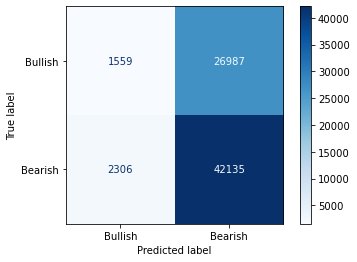

In [94]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Logistic Regression\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

In [39]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.2, 0.4, 0.6, 0.8, 1.0, 10], \
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Accuracy: 52.93 %
Standard Deviation: 0.48 %
Best Accuracy: 52.96 %
Best Parameters: {'C': 0.6, 'penalty': 'l2', 'solver': 'liblinear'}


## K-Nearest-Neighbors (KNN)

Classification Report for K-Nearest-Neighbors


              precision    recall  f1-score   support

     Bullish       0.39      0.36      0.37     28546
     Bearish       0.61      0.64      0.62     44441

    accuracy                           0.53     72987
   macro avg       0.50      0.50      0.50     72987
weighted avg       0.52      0.53      0.52     72987



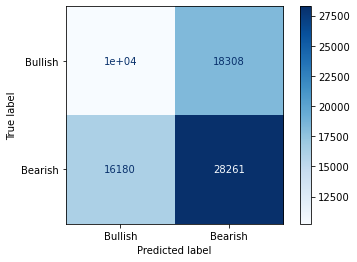

In [40]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for K-Nearest-Neighbors\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

In [41]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'n_neighbors': [5, 10, 20], 'weights': ['uniform', 'distance'], \
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Accuracy: 51.56 %
Standard Deviation: 1.55 %
Best Accuracy: 51.68 %
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'distance'}


## Kernel SVM

Classification Report for Kernel SVM


              precision    recall  f1-score   support

     Bullish       0.42      0.10      0.16     28546
     Bearish       0.61      0.91      0.73     44441

    accuracy                           0.59     72987
   macro avg       0.51      0.50      0.45     72987
weighted avg       0.54      0.59      0.51     72987



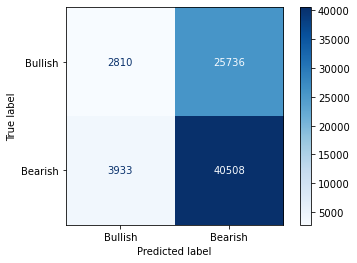

In [42]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test) 

#plot
print(f"Classification Report for Kernel SVM\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

In [43]:
# from sklearn.model_selection import cross_val_score
# accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
# print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

# # from sklearn.model_selection import GridSearchCV
# # parameters = [{'C': [0.2, 0.5, 1.0, 10.0], 'kernel': ['linear', 'rbf', 'sigmoid', 'precomputed']}, \
# #               {'C': [0.2, 0.5, 1.0, 10.0], 'kernel': ['poly'], 'degree': [2, 3, 4]}]
# # grid_search = GridSearchCV(estimator = classifier,
# #                            param_grid = parameters,
# #                            scoring = 'accuracy',
# #                            cv = 5,
# #                            n_jobs = -1)
# # grid_search.fit(X_train.values, y_train.values.ravel())
# # best_accuracy = grid_search.best_score_
# # best_parameters = grid_search.best_params_
# # print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# # print("Best Parameters:", best_parameters)

## Naive Bayes

Classification Report for Naive Bayes


              precision    recall  f1-score   support

     Bullish       0.39      0.92      0.55     28546
     Bearish       0.63      0.08      0.15     44441

    accuracy                           0.41     72987
   macro avg       0.51      0.50      0.35     72987
weighted avg       0.53      0.41      0.31     72987



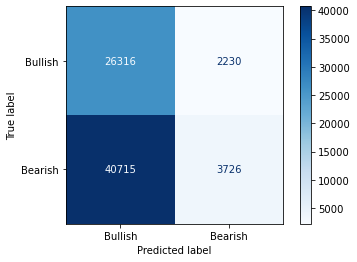

In [44]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Naive Bayes\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

Classification Report for Naive Bayes


              precision    recall  f1-score   support

     Bullish       0.42      0.13      0.20     28546
     Bearish       0.61      0.88      0.72     44441

    accuracy                           0.59     72987
   macro avg       0.52      0.51      0.46     72987
weighted avg       0.54      0.59      0.52     72987



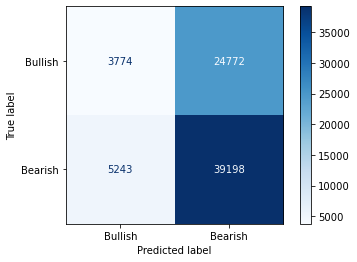

In [45]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Naive Bayes\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

In [46]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'alpha': [0.0, 0.2, 0.5, 1.0]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Accuracy: 52.73 %
Standard Deviation: 0.67 %
Best Accuracy: 52.64 %
Best Parameters: {'alpha': 0.0}


/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


## Decision Tree Classification

Classification Report for Decision Tree Classification


              precision    recall  f1-score   support

     Bullish       0.41      0.24      0.30     28546
     Bearish       0.62      0.79      0.69     44441

    accuracy                           0.57     72987
   macro avg       0.52      0.51      0.50     72987
weighted avg       0.54      0.57      0.54     72987



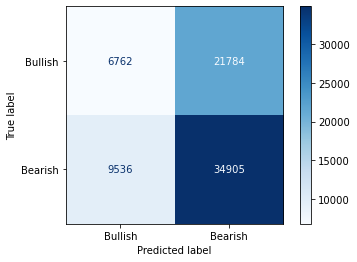

In [47]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Decision Tree Classification\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

## Random Forest Classification

Classification Report for Random Forest Classification


              precision    recall  f1-score   support

     Bullish       0.41      0.23      0.29     28546
     Bearish       0.61      0.79      0.69     44441

    accuracy                           0.57     72987
   macro avg       0.51      0.51      0.49     72987
weighted avg       0.53      0.57      0.54     72987



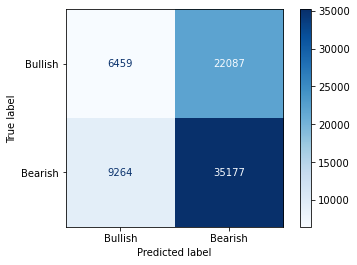

In [48]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test) 

#plot
print(f"Classification Report for Random Forest Classification\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

In [49]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [2, 4, 8, 16, 20], 'criterion': ['entropy', 'gini']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Accuracy: 52.70 %
Standard Deviation: 2.46 %
Best Accuracy: 52.20 %
Best Parameters: {'criterion': 'gini', 'n_estimators': 20}


## Neural Network

In [50]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten


In [51]:
# X_test = TWEETS_DF_TESTING.iloc[:, :-1]
# X_train = TWEETS_DF_TRAINING.iloc[:, :-1]

In [52]:
#reshape as correct shape for input LSTM model
X_train_ = np.reshape(X_train.values, (X_train.values.shape[0], X_train.values.shape[1], 1))

nn = Sequential()
nn.add(LSTM(units = 128, activation='relu', return_sequences = True, input_shape=(X_train_.shape[1], 1)))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 128, activation='relu', return_sequences = True))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 64, activation='relu', return_sequences = False))
nn.add(Flatten())
#output one value (Dense layer)
nn.add(Dense(units=1, activation='sigmoid')) 

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# nn.save('tweet_prediction.h5')
nn.fit(X_train_, y_train, epochs=10, batch_size=64)

Epoch 1/10
2771/2771 [==============================] - 34s 12ms/step - loss: 0.6918 - accuracy: 0.5278 - precision: 0.5279 - recall: 0.9977
Epoch 2/10
2771/2771 [==============================] - 33s 12ms/step - loss: 0.6913 - accuracy: 0.5283 - precision: 0.5293 - recall: 0.9621
Epoch 3/10
2771/2771 [==============================] - 38s 14ms/step - loss: 0.6913 - accuracy: 0.5288 - precision: 0.5303 - recall: 0.9404
Epoch 4/10
2771/2771 [==============================] - 34s 12ms/step - loss: 0.6912 - accuracy: 0.5297 - precision: 0.5309 - recall: 0.9364
Epoch 5/10
2771/2771 [==============================] - 33s 12ms/step - loss: 0.6912 - accuracy: 0.5297 - precision: 0.5314 - recall: 0.9227
Epoch 6/10
2771/2771 [==============================] - 34s 12ms/step - loss: 0.6912 - accuracy: 0.5298 - precision: 0.5317 - recall: 0.9181
Epoch 7/10
2771/2771 [==============================] - 36s 13ms/step - loss: 0.6911 - accuracy: 0.5301 - precision: 0.5321 - recall: 0.9111
Epoch 8/10
27

In [53]:
X_test_ = np.reshape(X_test.values, (X_test.values.shape[0], X_test.values.shape[1], 1))
test_loss, test_acc, test_prec, test_rec = nn.evaluate(X_test_, y_test.values)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_prec)
print('Test recall:', test_rec)

2281/2281 [==============================] - 7s 3ms/step - loss: 0.6794 - accuracy: 0.5951 - precision: 0.6108 - recall: 0.9231
Test loss: 0.6793832778930664
Test accuracy: 0.5950511693954468
Test precision: 0.6108124852180481
Test recall: 0.9231115579605103


In [54]:
# predict 
y_predicted = nn.predict(X_test_)

# round predictions 
y_predicted = np.array([[round(x[0]) for x in y_predicted]]).reshape(-1,1)
y_predicted

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [55]:
# #plot
# print(f"Classification Report for Classification Neural Network\n\n")
# print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
# # plot_confusion_matrix(nn, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
# # plt.show()  

In [61]:
TWEETS_DF['date']

0         2020-12-29 18:53:03
1         2020-12-29 17:53:19
2         2020-12-29 17:36:30
3         2020-12-29 17:20:05
4         2020-12-29 17:14:16
                 ...         
250300    2016-01-25 22:40:56
250301    2016-01-25 22:01:21
250302    2016-01-25 21:24:22
250303    2016-01-25 21:04:16
250304    2016-01-25 20:51:43
Name: date, Length: 250305, dtype: object

In [90]:
df_predicted = pd.DataFrame(TWEETS_DF['date'][:i], columns=['date'])
df_predicted

,date
0,2020-12-29 18:53:03
1,2020-12-29 17:53:19
2,2020-12-29 17:36:30
3,2020-12-29 17:20:05
4,2020-12-29 17:14:16
...,...
72982,2020-02-03 16:21:11
72983,2020-02-03 16:19:26
72984,2020-02-03 16:17:58
72985,2020-02-03 16:17:30


In [93]:
df_predicted['nn_prediction'] = y_predicted
df_predicted

,date,nn_prediction
0,2020-12-29 18:53:03,1.0
1,2020-12-29 17:53:19,1.0
2,2020-12-29 17:36:30,1.0
3,2020-12-29 17:20:05,1.0
4,2020-12-29 17:14:16,1.0
...,...,...
72982,2020-02-03 16:21:11,1.0
72983,2020-02-03 16:19:26,1.0
72984,2020-02-03 16:17:58,1.0
72985,2020-02-03 16:17:30,1.0


In [95]:
df_predicted['lr_prediction'] = y_predicted
df_predicted

,date,nn_prediction,lr_prediction
0,2020-12-29 18:53:03,1.0,1.0
1,2020-12-29 17:53:19,1.0,1.0
2,2020-12-29 17:36:30,1.0,1.0
3,2020-12-29 17:20:05,1.0,1.0
4,2020-12-29 17:14:16,1.0,1.0
...,...,...,...
72982,2020-02-03 16:21:11,1.0,1.0
72983,2020-02-03 16:19:26,1.0,1.0
72984,2020-02-03 16:17:58,1.0,1.0
72985,2020-02-03 16:17:30,1.0,1.0


In [105]:
df_predicted['stonk_pct_change'] = y_test

In [106]:
df_predicted

,date,nn_prediction,lr_prediction,stonk_pct_change
0,2020-12-29 18:53:03,1.0,1.0,1.0
1,2020-12-29 17:53:19,1.0,1.0,1.0
2,2020-12-29 17:36:30,1.0,1.0,1.0
3,2020-12-29 17:20:05,1.0,1.0,1.0
4,2020-12-29 17:14:16,1.0,1.0,1.0
...,...,...,...,...
72982,2020-02-03 16:21:11,1.0,1.0,1.0
72983,2020-02-03 16:19:26,1.0,1.0,1.0
72984,2020-02-03 16:17:58,1.0,1.0,1.0
72985,2020-02-03 16:17:30,1.0,1.0,1.0


In [9]:
df_regression = pd.read_csv('regression.csv')
df_regression

,Date,Ticker,y_true,y_predicted_dt,y_predicted_rf
0,2020-03-28,AAPL,0,0,0
1,2020-06-27,AAPL,1,1,1
2,2020-09-26,AAPL,1,1,1
3,2020-03-31,TSLA,1,1,1
4,2020-06-30,TSLA,1,1,1
5,2020-09-30,TSLA,1,1,1
6,2020-12-31,TSLA,1,1,1


In [10]:
df_reddit = pd.read_csv('reddit_nn.csv').drop(['Unnamed: 0'], axis=1)
df_reddit

,Date,AAPL_pct_change,NB_Ber_Predictions,Decision_Tree_Predictions,Stock
0,12/31/2020,0,1,1,AAPL
1,12/31/2020,0,1,0,AAPL
2,12/31/2020,0,1,0,AAPL
3,12/31/2020,0,1,1,AAPL
4,12/31/2020,0,1,0,AAPL
...,...,...,...,...,...
443551,1/2/2020,1,0,1,TSLA
443552,1/2/2020,1,0,1,TSLA
443553,1/2/2020,1,1,1,TSLA
443554,1/2/2020,1,0,0,TSLA


In [6]:
df_predicted = pd.read_csv("DF_PREDICTED.csv").drop(['Unnamed: 0'], axis=1)

# combine from different algorithms

In [216]:
df_predicted.drop_duplicates()

,Date,nn_prediction,lr_prediction,stonk_pct_change
0,2020-12-29,1.0,1.0,1.0
10,2020-12-29,0.0,0.0,1.0
81,2020-12-29,0.0,1.0,1.0
97,2020-12-29,1.0,0.0,1.0
100,2020-12-07,1.0,1.0,1.0
...,...,...,...,...
72621,2020-01-03,0.0,1.0,1.0
72677,2020-01-03,0.0,0.0,1.0
72826,2020-01-02,0.0,1.0,1.0
72827,2020-01-02,1.0,1.0,1.0


In [217]:
df_reddit.drop_duplicates()

,Date,stonk_pct_change,NB_Ber_Predictions,Decision_Tree_Predictions,Stock
0,2020-12-31,0,1,1,AAPL
1,2020-12-31,0,1,0,AAPL
476,2020-12-30,0,1,1,AAPL
477,2020-12-30,0,1,0,AAPL
939,2020-12-29,0,1,0,AAPL
...,...,...,...,...,...
442846,2020-01-03,1,0,1,TSLA
443244,2020-01-02,1,1,1,TSLA
443245,2020-01-02,1,0,1,TSLA
443249,2020-01-02,1,0,0,TSLA


In [302]:
merged_df = df_reddit.drop_duplicates().sort_values(['Date'], ascending=False).merge(\
             df_predicted.drop_duplicates().sort_values(['Date'], ascending=False), on=['stonk_pct_change'])
merged_df

,Date_x,stonk_pct_change,NB_Ber_Predictions,Decision_Tree_Predictions,Stock,Date_y,nn_prediction,lr_prediction
0,2020-12-31,0,1,1,AAPL,2020-12-22,0.0,1.0
1,2020-12-31,0,1,1,AAPL,2020-12-22,0.0,0.0
2,2020-12-31,0,1,1,AAPL,2020-12-22,1.0,1.0
3,2020-12-31,0,1,1,AAPL,2020-12-21,1.0,0.0
4,2020-12-31,0,1,1,AAPL,2020-12-21,0.0,0.0
...,...,...,...,...,...,...,...,...
645271,2020-01-02,1,1,0,TSLA,2020-01-03,0.0,1.0
645272,2020-01-02,1,1,0,TSLA,2020-01-03,0.0,0.0
645273,2020-01-02,1,1,0,TSLA,2020-01-02,0.0,1.0
645274,2020-01-02,1,1,0,TSLA,2020-01-02,1.0,1.0


In [11]:
df_predicted
df_reddit
# df_regression

,Date,Ticker,y_true,y_predicted_dt,y_predicted_rf
0,2020-03-28,AAPL,0,0,0
1,2020-06-27,AAPL,1,1,1
2,2020-09-26,AAPL,1,1,1
3,2020-03-31,TSLA,1,1,1
4,2020-06-30,TSLA,1,1,1
5,2020-09-30,TSLA,1,1,1
6,2020-12-31,TSLA,1,1,1


In [25]:
df_reddit.rename(columns={'AAPL_pct_change':'stonk_pct_change'}, inplace=True)

In [ ]:
df_regression.rename(columns={'Ticker':'Stock'})

In [366]:
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'], format='%m/%d/%Y')

df_predicted['Date'] = [str(i).split()[0] for i in df_predicted['Date']]
df_predicted['Date'] = pd.to_datetime(df_predicted['Date'], format='%Y/%m/%d')

df_regression['Date'] = pd.to_datetime(df_regression['Date'], format='%Y/%m/%d')


df_reddit

,Date,stonk_pct_change,NB_Ber_Predictions,Decision_Tree_Predictions,Stock
0,2020-12-31,0,1,1,AAPL
1,2020-12-31,0,1,0,AAPL
2,2020-12-31,0,1,0,AAPL
3,2020-12-31,0,1,1,AAPL
4,2020-12-31,0,1,0,AAPL
...,...,...,...,...,...
443551,2020-01-02,1,0,1,TSLA
443552,2020-01-02,1,0,1,TSLA
443553,2020-01-02,1,1,1,TSLA
443554,2020-01-02,1,0,0,TSLA


In [359]:
# df_predicted.merge(df_reddit, on=['Date', 'stonk_pct_change'])
merged_df = df_predicted.merge(df_reddit, on=['Date', 'stonk_pct_change']).dropna(axis=0)

In [360]:
merged_df

,Date,nn_prediction,lr_prediction,stonk_pct_change,NB_Ber_Predictions,Decision_Tree_Predictions,Stock
0,2020-12-29,1.0,1.0,1.0,1,0,TSLA
1,2020-12-29,1.0,1.0,1.0,1,1,TSLA
2,2020-12-29,1.0,1.0,1.0,1,0,TSLA
3,2020-12-29,1.0,1.0,1.0,0,1,TSLA
4,2020-12-29,1.0,1.0,1.0,0,1,TSLA
...,...,...,...,...,...,...,...
109928037,2020-01-02,1.0,1.0,1.0,0,1,TSLA
109928038,2020-01-02,1.0,1.0,1.0,0,1,TSLA
109928039,2020-01-02,1.0,1.0,1.0,1,1,TSLA
109928040,2020-01-02,1.0,1.0,1.0,0,0,TSLA


In [415]:
merged_df = merged_df.drop_duplicates().sort_values(['Date'], ascending=False).reset_index(drop=True)
merged_df

,Date,nn_prediction,lr_prediction,stonk_pct_change,NB_Ber_Predictions,Decision_Tree_Predictions,Stock
0,2020-12-29,1.0,1.0,1.0,1,0,TSLA
1,2020-12-29,1.0,0.0,1.0,1,0,TSLA
2,2020-12-29,0.0,0.0,1.0,1,0,TSLA
3,2020-12-29,0.0,1.0,1.0,1,0,TSLA
4,2020-12-29,1.0,1.0,1.0,1,1,TSLA
...,...,...,...,...,...,...,...
4399,2020-01-02,0.0,1.0,1.0,1,0,AAPL
4400,2020-01-02,0.0,1.0,1.0,1,1,AAPL
4401,2020-01-02,1.0,1.0,1.0,1,1,TSLA
4402,2020-01-02,1.0,1.0,1.0,1,0,TSLA


In [408]:
from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [423]:
df_test = pd.DataFrame(data=[], columns=['nn_prediction', 'lr_prediction', 'NB_Ber_Predictions', 'Decision_Tree_Predictions'])


# take the average of each time period and make that the correct prediction
prev = None
for d in df_regression['Date']:
    for i, j in enumerate(merged_df['Date']):
        if (days_between(str(j).split()[0], str(d).split()[0]) <= 1 or days_between(str(j).split()[0], str(d).split()[0]) <= 2) and prev:
            print(d)
            df_test = df_test.append(merged_df.drop(['Date', 'Stock', 'stonk_pct_change'], axis=1).iloc[i:prev, :].mean(), ignore_index=True)
            break
        elif (days_between(str(j).split()[0], str(d).split()[0]) <= 1 or days_between(str(j).split()[0], str(d).split()[0]) <= 2) and not prev:
            print(d)
            df_test = df_test.append(merged_df.drop(['Date', 'Stock', 'stonk_pct_change'], axis=1).iloc[i:, :].mean(), ignore_index=True)
            break
                

2020-03-28 00:00:00
2020-06-27 00:00:00
2020-09-26 00:00:00
2020-03-31 00:00:00
2020-06-30 00:00:00
2020-09-30 00:00:00
2020-12-31 00:00:00


In [431]:
new_merged_df = df_regression.merge(df_test, left_index=True, right_index=True)
new_merged_df

,Date,Ticker,y_true,y_predicted_dt,y_predicted_rf,nn_prediction,lr_prediction,NB_Ber_Predictions,Decision_Tree_Predictions
0,2020-03-28,AAPL,0,0,0,0.424951,0.578947,0.610136,0.5
1,2020-06-27,AAPL,1,1,1,0.414587,0.595969,0.618042,0.5
2,2020-09-26,AAPL,1,1,1,0.427791,0.578883,0.623180,0.5
3,2020-03-31,TSLA,1,1,1,0.423507,0.580224,0.608209,0.5
4,2020-06-30,TSLA,1,1,1,0.414406,0.595884,0.618335,0.5
5,2020-09-30,TSLA,1,1,1,0.427553,0.580760,0.624109,0.5
6,2020-12-31,TSLA,1,1,1,0.427793,0.579473,0.621708,0.5


In [485]:
# Traing on 80% of the data and predict 20%
# w = 0.2
# X_test = merged_df.drop(['stonk_pct_change', 'Stock'], axis=1).iloc[:int(merged_df.shape[0]*w), 1:-1]
# X_train = merged_df.drop(['stonk_pct_change', 'Stock'], axis=1).iloc[int(merged_df.shape[0]*w):, 1:-1]

# y_test = merged_df['stonk_pct_change'][:int(merged_df.shape[0]*w)]
# y_train = merged_df['stonk_pct_change'][int(merged_df.shape[0]*w):]

X = new_merged_df.drop(['y_true', 'Ticker', 'Date'], axis=1)
y = new_merged_df[['y_true']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)

print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(4, 6)
(3, 6)
(4, 1)
(3, 1)


In [486]:
y_test

,y_true
6,1
1,1
0,0
4,1


In [337]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, GRU, SimpleRNN, Conv1D


In [487]:
s = StandardScaler()

X_train_sc = s.fit_transform(X_train.values)
X_test_sc = s.transform(X_test.values)

In [527]:
#reshape as correct shape for input LSTM model
X_train_ = np.reshape(X_train_sc.astype(np.float16), (X_train.values.shape[0], X_train.values.shape[1], 1))

nn = Sequential()
nn.add(LSTM(units = 32, activation='relu', return_sequences = True, input_shape=(X_train_.shape[1], 1)))
nn.add(Dense(units=32, activation='relu'))
nn.add(Dropout(0.2))

nn.add(Flatten())
#output one value (Dense layer)
nn.add(Dense(units=1, activation='hard_sigmoid')) 

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# nn.save('tweet_prediction.h5')
nn.fit(X_train_, y_train.astype(np.float16), epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 0.6751 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 846us/step - loss: 0.6725 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 967us/step - loss: 0.6646 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 800us/step - loss: 0.6666 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 852us/step - loss: 0.6544 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 876us/step - loss: 0.6582 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 901us/step - loss: 0.6509 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 898u

In [528]:
X_test_ = np.reshape(X_test.values, (X_test.values.shape[0], X_test.values.shape[1], 1))
test_loss, test_acc, test_prec, test_rec = nn.evaluate(X_test_, y_test.values)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_prec)
print('Test recall:', test_rec)

1/1 [==============================] - 0s 966us/step - loss: 0.6450 - accuracy: 0.7500 - precision: 0.7500 - recall: 1.0000
Test loss: 0.6450320482254028
Test accuracy: 0.75
Test precision: 0.75
Test recall: 1.0


In [529]:
# predict 
y_predicted = (nn.predict(X_test_) > stats.median(nn.predict(X_test_))).astype("int32")

# y_predicted = (nn.predict(X_test_) > 0.5).astype("int32")

In [530]:
print(y_predicted.sum(), y_predicted.shape[0])

2 4


Classification Report for NN


              precision    recall  f1-score   support

     Bullish       0.50      1.00      0.67         1
     Bearish       1.00      0.67      0.80         3

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4



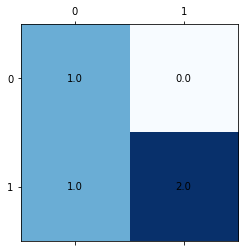

In [531]:
from sklearn.metrics import confusion_matrix

#plot
print(f"Classification Report for NN\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))

fig, ax = plt.subplots()
ax.matshow(confusion_matrix(y_test, y_predicted), cmap=plt.cm.Blues, )
for (i, j), z in np.ndenumerate(confusion_matrix(y_test, y_predicted)):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
# plt.colorbar()
plt.show()

In [532]:
nn.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_313 (LSTM)              (None, 6, 32)             4352      
_________________________________________________________________
dense_127 (Dense)            (None, 6, 32)             1056      
_________________________________________________________________
dropout_270 (Dropout)        (None, 6, 32)             0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 193       
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


### Logistic Regression

In [534]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Logistic Regression\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

Accuracy: 58.63 %
Standard Deviation: 0.10 %
Best Accuracy: 58.63 %
Best Parameters: {'C': 0.2, 'penalty': 'l1', 'solver': 'liblinear'}


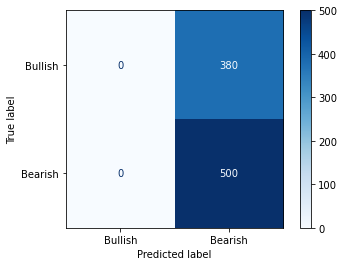

In [89]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.2, 0.4, 0.6, 0.8, 1.0, 10], \
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_searc## K-Nearest-Neighbors (KNN)h.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

# predict 
y_predicted = grid_search.predict(X_test.values) 

#plot
plot_confusion_matrix(grid_search, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

## K-Nearest-Neighbors (KNN)

Classification Report for K-Nearest-Neighbors


              precision    recall  f1-score   support

     Bullish       0.42      0.52      0.46       380
     Bearish       0.55      0.45      0.50       500

    accuracy                           0.48       880
   macro avg       0.49      0.48      0.48       880
weighted avg       0.49      0.48      0.48       880



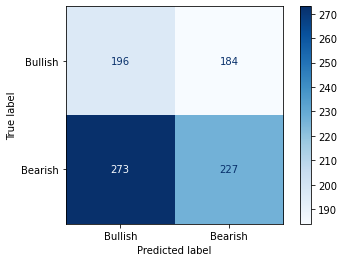

In [104]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for K-Nearest-Neighbors\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

Accuracy: 54.03 %
Standard Deviation: 3.32 %
Best Accuracy: 54.40 %
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'}


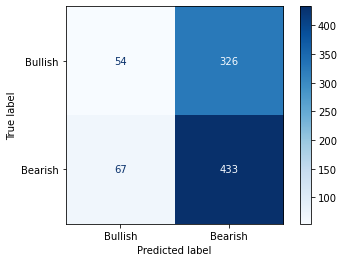

In [105]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'n_neighbors': [5, 10, 20, 30], 'weights': ['uniform', 'distance'], \
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

# predict 
y_predicted = grid_search.predict(X_test.values) 

#plot
plot_confusion_matrix(grid_search, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show() 

# Kernel SVM

Classification Report for Kernel SVM


              precision    recall  f1-score   support

     Bullish       0.00      0.00      0.00       380
     Bearish       0.57      1.00      0.72       500

    accuracy                           0.57       880
   macro avg       0.28      0.50      0.36       880
weighted avg       0.32      0.57      0.41       880



/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


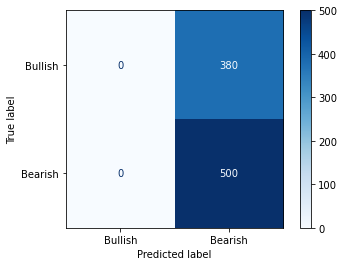

In [92]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test) 

#plot
print(f"Classification Report for Kernel SVM\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

Accuracy: 58.63 %
Standard Deviation: 0.10 %
Best Accuracy: 58.63 %
Best Parameters: {'C': 0.2, 'kernel': 'linear'}


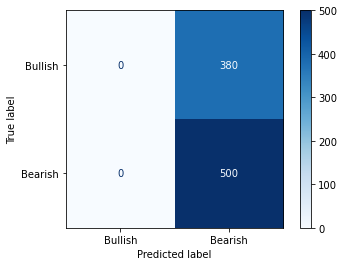

In [94]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.2, 0.5, 1.0, 10.0], 'kernel': ['linear', 'rbf', 'sigmoid']}, \
              {'C': [0.2, 0.5, 1.0, 10.0], 'kernel': ['poly'], 'degree': [2, 3, 4]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

# predict 
y_predicted = grid_search.predict(X_test.values) 

#plot
plot_confusion_matrix(grid_search, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show() 

## Naive Bayes

Classification Report for Naive Bayes


              precision    recall  f1-score   support

     Bullish       0.00      0.00      0.00       380
     Bearish       0.57      1.00      0.72       500

    accuracy                           0.57       880
   macro avg       0.28      0.50      0.36       880
weighted avg       0.32      0.57      0.41       880



/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


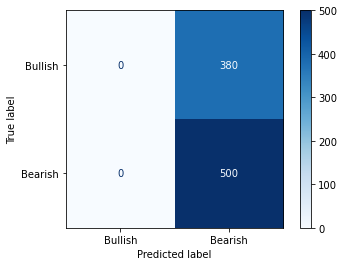

In [95]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Naive Bayes\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

Classification Report for Naive Bayes


              precision    recall  f1-score   support

     Bullish       0.00      0.00      0.00       380
     Bearish       0.57      1.00      0.72       500

    accuracy                           0.57       880
   macro avg       0.28      0.50      0.36       880
weighted avg       0.32      0.57      0.41       880



/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


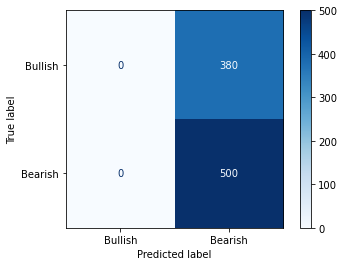

In [96]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Naive Bayes\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

Accuracy: 58.63 %
Standard Deviation: 0.10 %
Best Accuracy: 58.63 %
Best Parameters: {'alpha': 0.0}


/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


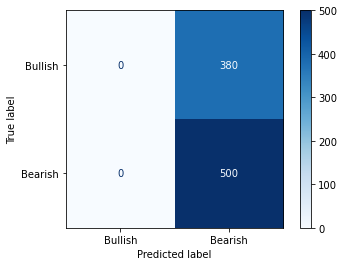

In [97]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'alpha': [0.0, 0.2, 0.5, 1.0]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

# predict 
y_predicted = grid_search.predict(X_test.values) 

#plot
plot_confusion_matrix(grid_search, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show() 

## Decision Tree Classification

Classification Report for Decision Tree Classification


              precision    recall  f1-score   support

     Bullish       0.00      0.00      0.00       380
     Bearish       0.57      1.00      0.72       500

    accuracy                           0.57       880
   macro avg       0.28      0.50      0.36       880
weighted avg       0.32      0.57      0.41       880



/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


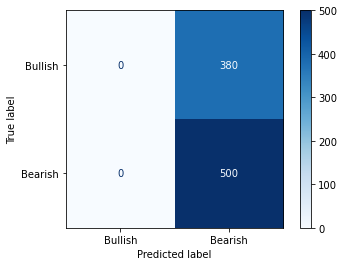

In [98]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test.values) 

#plot
print(f"Classification Report for Decision Tree Classification\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

## Random Forest Classification

Classification Report for Random Forest Classification


              precision    recall  f1-score   support

     Bullish       0.00      0.00      0.00       380
     Bearish       0.57      1.00      0.72       500

    accuracy                           0.57       880
   macro avg       0.28      0.50      0.36       880
weighted avg       0.32      0.57      0.41       880



/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


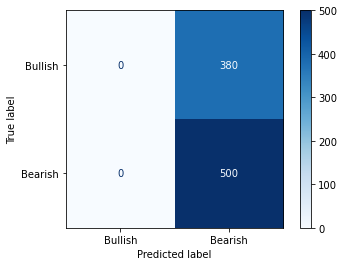

In [107]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train.values, y_train.values.ravel())

# predict 
y_predicted = classifier.predict(X_test) 

#plot
print(f"Classification Report for Random Forest Classification\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))
plot_confusion_matrix(classifier, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show()  

Accuracy: 58.63 %
Standard Deviation: 0.10 %
Best Accuracy: 58.63 %
Best Parameters: {'criterion': 'entropy', 'n_estimators': 8}


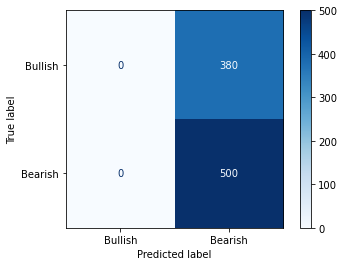

In [108]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train.values, y = y_train.values.ravel(), cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [2, 4, 8, 16, 20], 'criterion': ['entropy', 'gini']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 15,
                           n_jobs = -1)
grid_search.fit(X_train.values, y_train.values.ravel())
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

# predict 
y_predicted = grid_search.predict(X_test.values) 

#plot
plot_confusion_matrix(grid_search, X_test.values, y_test.values, cmap=plt.cm.Blues, display_labels=['Bullish', 'Bearish'])  
plt.show() 

# Regression

In [137]:
X_train_.shape

(3524, 4, 1)

In [215]:
print(y_test.shape)
print(y_test.sum())
print(y_test.sum()/y_test.shape[0])

print(y_train.shape)
print(y_train.sum())
print(y_train.sum()/y_train.shape[0])


(880,)
500.0
0.5681818181818182
(3524,)
2066.0
0.5862656072644722


In [208]:
#reshape as correct shape for input LSTM model
X_train_ = np.reshape(X_train.values, (X_train.values.shape[0], X_train.values.shape[1], 1))

nn = Sequential()
nn.add(LSTM(units = 128, activation='relu', return_sequences = True, input_shape=(X_train_[0].reshape(1,-1, 1).shape[1], 1)))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 128, activation='relu', return_sequences = True))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 128, activation='relu', return_sequences = True))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 128, activation='relu', return_sequences = True))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 128, activation='relu', return_sequences = True))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 128, activation='relu', return_sequences = True))
nn.add(Dropout(0.2))
nn.add(LSTM(units = 64, activation='relu', return_sequences = False))
nn.add(Flatten())
#output one value (Dense layer)
nn.add(Dense(units=1, activation='sigmoid')) 

nn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# nn.save('tweet_prediction.h5')
nn.fit(X_train_[0].reshape(1,-1, 1), np.expand_dims(y_train.iloc[0], axis=0), epochs=15, batch_size=1)

Epoch 1/15
1/1 [==============================] - 0s 886us/step - loss: 0.2500 - mae: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 1ms/step - loss: 0.2490 - mae: 0.4990
Epoch 3/15
1/1 [==============================] - 0s 889us/step - loss: 0.2478 - mae: 0.4978
Epoch 4/15
1/1 [==============================] - 0s 999us/step - loss: 0.2465 - mae: 0.4965
Epoch 5/15
1/1 [==============================] - 0s 910us/step - loss: 0.2451 - mae: 0.4951
Epoch 6/15
1/1 [==============================] - 0s 914us/step - loss: 0.2437 - mae: 0.4937
Epoch 7/15
1/1 [==============================] - 0s 935us/step - loss: 0.2421 - mae: 0.4920
Epoch 8/15
1/1 [==============================] - 0s 1ms/step - loss: 0.2401 - mae: 0.4900
Epoch 9/15
1/1 [==============================] - 0s 1ms/step - loss: 0.2381 - mae: 0.4880
Epoch 10/15
1/1 [==============================] - 0s 2ms/step - loss: 0.2361 - mae: 0.4859
Epoch 11/15
1/1 [==============================] - 0s 1ms/step - loss: 0.2337

In [209]:
np.expand_dims(y_train.iloc[0], axis=0)

array([0.])

In [210]:
nn.predict(X_train_[0].reshape(1,-1, 1))

array([[0.46734366]], dtype=float32)

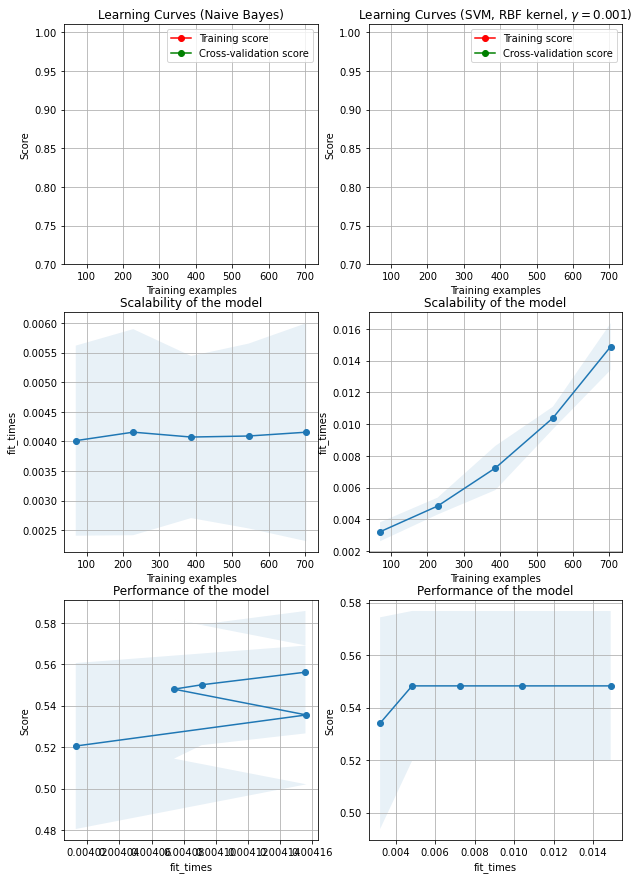

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_test, y_test, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X_test, y_test, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X_test, y_test, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

Classification Report for NN


              precision    recall  f1-score   support

     Bullish       0.00      0.00      0.00       380
     Bearish       0.57      1.00      0.72       500

    accuracy                           0.57       880
   macro avg       0.28      0.50      0.36       880
weighted avg       0.32      0.57      0.41       880



/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


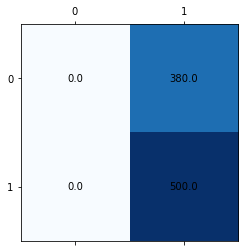

In [115]:
# predict 
y_predicted = (nn.predict(X_test_) > 0.5).astype("int32")

from sklearn.metrics import confusion_matrix

#plot
print(f"Classification Report for NN\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))

fig, ax = plt.subplots()
ax.matshow(confusion_matrix(y_test, y_predicted), cmap=plt.cm.Blues, )
for (i, j), z in np.ndenumerate(confusion_matrix(y_test, y_predicted)):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
# plt.colorbar()
plt.show()


In [121]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


XGBModel = XGBRegressor()
XGBModel.fit(X_train,y_train , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = mean_absolute_error(y_test , XGBpredictions)
MSE = mean_squared_error(y_test , XGBpredictions)

print('XGBoost validation MAE = ', MAE)
print('XGBoost validation MSE = ', MSE)

XGBoost validation MAE =  0.48944909342310644
XGBoost validation MSE =  0.24695964631061731


In [129]:
y_prediction = (XGBpredictions > XGBpredictions.mean()).astype("int32").reshape(-1,)

In [132]:
y_predicted.sum()

880

Classification Report for NN


              precision    recall  f1-score   support

     Bullish       0.00      0.00      0.00       380
     Bearish       0.57      1.00      0.72       500

    accuracy                           0.57       880
   macro avg       0.28      0.50      0.36       880
weighted avg       0.32      0.57      0.41       880



/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


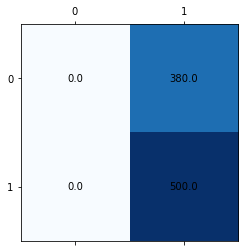

In [130]:
from sklearn.metrics import confusion_matrix

#plot
print(f"Classification Report for NN\n\n")
print(classification_report(y_test.values, y_predicted, target_names=['Bullish', 'Bearish']))

fig, ax = plt.subplots()
ax.matshow(confusion_matrix(y_test, y_predicted), cmap=plt.cm.Blues, )
for (i, j), z in np.ndenumerate(confusion_matrix(y_test, y_predicted)):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
# plt.colorbar()
plt.show()
